In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Create directory for saving models
save_path = '/content/drive/MyDrive/covid_models/'
os.makedirs(save_path, exist_ok=True)

# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

Mounted at /content/drive


In [ ]:
# Define the COVID-19 dataset class
class CovidDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = ['covid', 'healthy']

        self.image_paths = []
        self.labels = []

        # Load the image paths and labels
        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(data_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(img_path)
                    self.labels.append(class_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        # Load as grayscale (L mode)
        image = Image.open(img_path).convert('L')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        # Repeat the single channel 3 times to match ResNet input
        image = image.repeat(3, 1, 1)

        return image, label

In [ ]:
# Define the data transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229]) # Single channel normalization
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229]) # Single channel normalization
])

In [ ]:
# Define the modified ResNet50 model
class CovidResNet50(nn.Module):
    def __init__(self):
        super(CovidResNet50, self).__init__()
        # Load pretrained model
        self.model = models.resnet50(pretrained=True)

        # Modify first conv layer to accept grayscale
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Freeze early layers
        for param in list(self.model.parameters())[:-20]:
            param.requires_grad = False

        # Modify final layers
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Define functions for saving and exporting the model
def save_model(model, optimizer, train_acc, test_acc, epoch, filename):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_acc': train_acc,
        'test_acc': test_acc,
    }, filename)

def save_model_for_inference(model, filename):
    model.eval()
    torch.save(model.state_dict(), filename)

def export_to_onnx(model, filename):
    model.eval()
    dummy_input = torch.randn(1, 3, 224, 224, device=next(model.parameters()).device)
    torch.onnx.export(model, dummy_input, filename,
                     export_params=True,
                     opset_version=11,
                     do_constant_folding=True,
                     input_names=['input'],
                     output_names=['output'],
                     dynamic_axes={'input': {0: 'batch_size'},
                                 'output': {0: 'batch_size'}})

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(fpr, tpr, roc_auc):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['COVID', 'Healthy'], rotation=45)
    plt.yticks(tick_marks, ['COVID', 'Healthy'])

    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, conf_matrix[i, j],
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Define the training and evaluation functions
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    predictions, labels_list = [], []

    for inputs, labels in tqdm(train_loader, desc='Training'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = accuracy_score(labels_list, predictions)
    return epoch_loss, epoch_acc

def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    predictions, labels_list = [], []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_loader)
    test_acc = accuracy_score(labels_list, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels_list, predictions, average='binary')
    conf_matrix = confusion_matrix(labels_list, predictions)

    fpr, tpr, _ = roc_curve(labels_list, predictions)
    roc_auc = auc(fpr, tpr)


    return test_loss, test_acc, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc

def predict_single_image(image_path, model, device):
    model.eval()

    # Prepare image
    image = Image.open(image_path).convert('L')
    image = test_transform(image)
    image = image.repeat(3, 1, 1) # Repeat channels
    image = image.unsqueeze(0)
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    return 'COVID' if predicted.item() == 0 else 'Healthy'

Using device: cuda
Training samples: 1112
Testing samples: 13808


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/25


Evaluating: 100%|██████████| 863/863 [00:59<00:00, 14.50it/s]


Train Loss: 0.4752 Train Acc: 0.8067
Test Loss: 0.4871 Test Acc: 0.7863
Precision: 0.8914 Recall: 0.8090 F1: 0.8482
Confusion Matrix:
[[2612 1004]
 [1947 8245]]
New best model saved with accuracy: 0.7863

Epoch 2/25


Evaluating: 100%|██████████| 863/863 [01:00<00:00, 14.28it/s]


Train Loss: 0.3217 Train Acc: 0.8669
Test Loss: 0.4662 Test Acc: 0.8141
Precision: 0.8426 Recall: 0.9199 F1: 0.8796
Confusion Matrix:
[[1865 1751]
 [ 816 9376]]
New best model saved with accuracy: 0.8141

Epoch 3/25


Evaluating: 100%|██████████| 863/863 [00:58<00:00, 14.74it/s]


Train Loss: 0.2808 Train Acc: 0.8831
Test Loss: 0.5949 Test Acc: 0.7882
Precision: 0.8259 Recall: 0.9036 F1: 0.8630
Confusion Matrix:
[[1675 1941]
 [ 983 9209]]

Epoch 4/25


Evaluating: 100%|██████████| 863/863 [00:58<00:00, 14.75it/s]


Train Loss: 0.2721 Train Acc: 0.8984
Test Loss: 0.4873 Test Acc: 0.8109
Precision: 0.8831 Recall: 0.8573 F1: 0.8700
Confusion Matrix:
[[2459 1157]
 [1454 8738]]

Epoch 5/25


Evaluating: 100%|██████████| 863/863 [00:59<00:00, 14.62it/s]


Train Loss: 0.2181 Train Acc: 0.9164
Test Loss: 0.6835 Test Acc: 0.7811
Precision: 0.9081 Recall: 0.7826 F1: 0.8407
Confusion Matrix:
[[2809  807]
 [2216 7976]]

Epoch 6/25


Evaluating: 100%|██████████| 863/863 [00:58<00:00, 14.69it/s]


Train Loss: 0.2287 Train Acc: 0.9074
Test Loss: 0.5686 Test Acc: 0.7977
Precision: 0.8814 Recall: 0.8389 F1: 0.8596
Confusion Matrix:
[[2465 1151]
 [1642 8550]]

Epoch 7/25


Evaluating: 100%|██████████| 863/863 [00:59<00:00, 14.44it/s]


Train Loss: 0.2033 Train Acc: 0.9299
Test Loss: 0.5521 Test Acc: 0.8036
Precision: 0.8738 Recall: 0.8578 F1: 0.8657
Confusion Matrix:
[[2353 1263]
 [1449 8743]]

Epoch 8/25


Evaluating: 100%|██████████| 863/863 [01:00<00:00, 14.15it/s]


Train Loss: 0.1772 Train Acc: 0.9290
Test Loss: 0.6055 Test Acc: 0.8010
Precision: 0.8791 Recall: 0.8468 F1: 0.8627
Confusion Matrix:
[[2429 1187]
 [1561 8631]]

Epoch 9/25


Evaluating: 100%|██████████| 863/863 [01:00<00:00, 14.23it/s]


Train Loss: 0.1624 Train Acc: 0.9469
Test Loss: 0.6386 Test Acc: 0.8009
Precision: 0.9005 Recall: 0.8209 F1: 0.8589
Confusion Matrix:
[[2692  924]
 [1825 8367]]

Epoch 10/25


Evaluating: 100%|██████████| 863/863 [00:57<00:00, 14.91it/s]


Train Loss: 0.1607 Train Acc: 0.9406
Test Loss: 0.6366 Test Acc: 0.8032
Precision: 0.8881 Recall: 0.8391 F1: 0.8629
Confusion Matrix:
[[2538 1078]
 [1640 8552]]

Epoch 11/25


Evaluating: 100%|██████████| 863/863 [00:59<00:00, 14.47it/s]


Train Loss: 0.1620 Train Acc: 0.9317
Test Loss: 0.6183 Test Acc: 0.8063
Precision: 0.8897 Recall: 0.8420 F1: 0.8652
Confusion Matrix:
[[2552 1064]
 [1610 8582]]

Epoch 12/25


Evaluating: 100%|██████████| 863/863 [00:58<00:00, 14.79it/s]


Train Loss: 0.1672 Train Acc: 0.9272
Test Loss: 0.5993 Test Acc: 0.8064
Precision: 0.8693 Recall: 0.8683 F1: 0.8688
Confusion Matrix:
[[2285 1331]
 [1342 8850]]

Epoch 13/25


Evaluating: 100%|██████████| 863/863 [01:00<00:00, 14.32it/s]


Train Loss: 0.1587 Train Acc: 0.9299
Test Loss: 0.6513 Test Acc: 0.8034
Precision: 0.8905 Recall: 0.8366 F1: 0.8627
Confusion Matrix:
[[2567 1049]
 [1665 8527]]

Epoch 14/25


Evaluating: 100%|██████████| 863/863 [00:58<00:00, 14.84it/s]


Train Loss: 0.1450 Train Acc: 0.9433
Test Loss: 0.6360 Test Acc: 0.8046
Precision: 0.8996 Recall: 0.8276 F1: 0.8621
Confusion Matrix:
[[2675  941]
 [1757 8435]]

Epoch 15/25


Evaluating: 100%|██████████| 863/863 [01:00<00:00, 14.37it/s]


Train Loss: 0.1534 Train Acc: 0.9379
Test Loss: 0.6264 Test Acc: 0.8059
Precision: 0.8931 Recall: 0.8372 F1: 0.8643
Confusion Matrix:
[[2595 1021]
 [1659 8533]]

Epoch 16/25


Evaluating: 100%|██████████| 863/863 [01:10<00:00, 12.27it/s]


Train Loss: 0.2007 Train Acc: 0.9227
Test Loss: 0.6449 Test Acc: 0.8042
Precision: 0.8930 Recall: 0.8347 F1: 0.8629
Confusion Matrix:
[[2597 1019]
 [1685 8507]]

Epoch 17/25


Evaluating: 100%|██████████| 863/863 [00:58<00:00, 14.71it/s]


Train Loss: 0.1386 Train Acc: 0.9505
Test Loss: 0.5995 Test Acc: 0.8058
Precision: 0.8874 Recall: 0.8440 F1: 0.8652
Confusion Matrix:
[[2525 1091]
 [1590 8602]]

Epoch 18/25


Evaluating: 100%|██████████| 863/863 [00:59<00:00, 14.39it/s]


Train Loss: 0.1668 Train Acc: 0.9326
Test Loss: 0.6274 Test Acc: 0.8050
Precision: 0.8810 Recall: 0.8508 F1: 0.8656
Confusion Matrix:
[[2445 1171]
 [1521 8671]]

Epoch 19/25


Evaluating: 100%|██████████| 863/863 [01:01<00:00, 13.96it/s]


Train Loss: 0.1695 Train Acc: 0.9353
Test Loss: 0.6348 Test Acc: 0.8054
Precision: 0.8988 Recall: 0.8298 F1: 0.8629
Confusion Matrix:
[[2664  952]
 [1735 8457]]

Epoch 20/25


Evaluating: 100%|██████████| 863/863 [00:58<00:00, 14.85it/s]


Train Loss: 0.1583 Train Acc: 0.9406
Test Loss: 0.6485 Test Acc: 0.8009
Precision: 0.8852 Recall: 0.8391 F1: 0.8615
Confusion Matrix:
[[2507 1109]
 [1640 8552]]

Epoch 21/25


Evaluating: 100%|██████████| 863/863 [00:59<00:00, 14.48it/s]


Train Loss: 0.1774 Train Acc: 0.9371
Test Loss: 0.6144 Test Acc: 0.8061
Precision: 0.8865 Recall: 0.8455 F1: 0.8655
Confusion Matrix:
[[2513 1103]
 [1575 8617]]

Epoch 22/25


Evaluating: 100%|██████████| 863/863 [00:57<00:00, 15.11it/s]


Train Loss: 0.1567 Train Acc: 0.9379
Test Loss: 0.6587 Test Acc: 0.8051
Precision: 0.8902 Recall: 0.8395 F1: 0.8641
Confusion Matrix:
[[2561 1055]
 [1636 8556]]

Epoch 23/25


Evaluating: 100%|██████████| 863/863 [00:59<00:00, 14.53it/s]


Train Loss: 0.1692 Train Acc: 0.9415
Test Loss: 0.6264 Test Acc: 0.8060
Precision: 0.8883 Recall: 0.8432 F1: 0.8652
Confusion Matrix:
[[2535 1081]
 [1598 8594]]

Epoch 24/25


Evaluating: 100%|██████████| 863/863 [01:00<00:00, 14.15it/s]


Train Loss: 0.1523 Train Acc: 0.9442
Test Loss: 0.7015 Test Acc: 0.7987
Precision: 0.9110 Recall: 0.8061 F1: 0.8553
Confusion Matrix:
[[2813  803]
 [1976 8216]]

Epoch 25/25


Evaluating: 100%|██████████| 863/863 [01:00<00:00, 14.33it/s]


Train Loss: 0.1558 Train Acc: 0.9442
Test Loss: 0.6432 Test Acc: 0.8038
Precision: 0.9017 Recall: 0.8241 F1: 0.8611
Confusion Matrix:
[[2700  916]
 [1793 8399]]

Training completed!
Best test accuracy: 0.8141

Test prediction on sample image: COVID


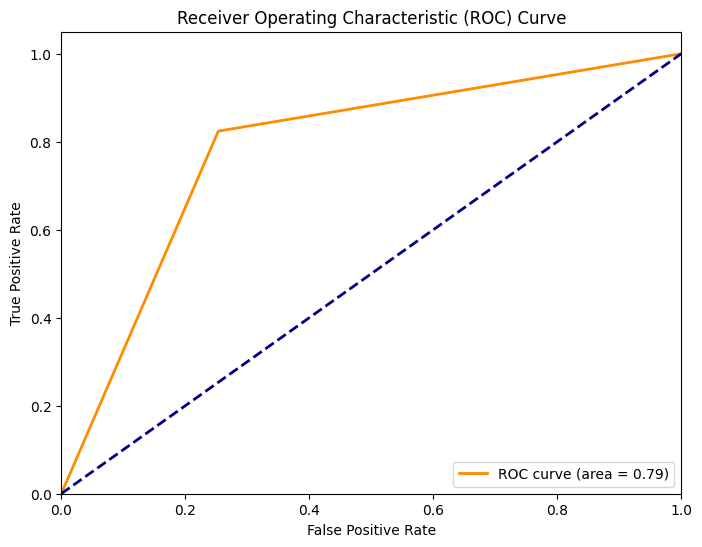

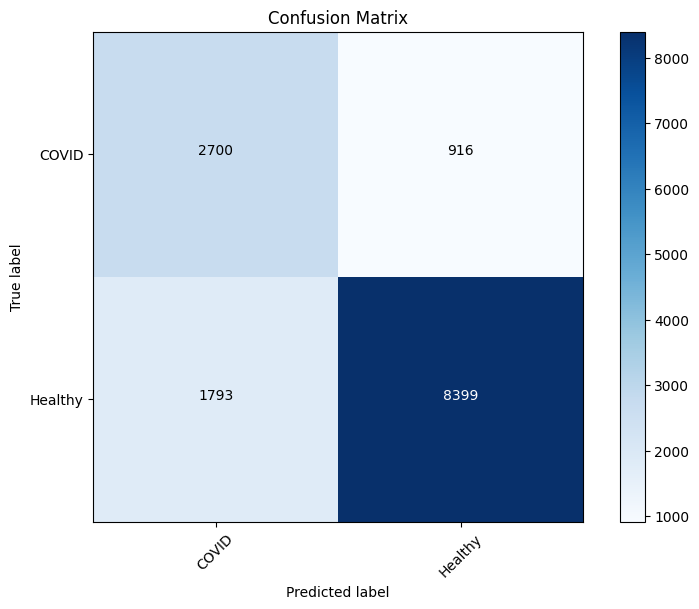

In [ ]:
# Main function to train and evaluate the model
def main():
    # Paths
    train_dir = '/content/covid-model/train'
    test_dir = '/content/covid-model/test'

    # Hyperparameters
    batch_size = 16
    num_epochs = 25
    learning_rate = 0.0001

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Datasets and loaders
    train_dataset = CovidDataset(train_dir, train_transform)
    test_dataset = CovidDataset(test_dir, test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Testing samples: {len(test_dataset)}")

    # Calculate class weights
    train_labels = torch.tensor(train_dataset.labels)
    class_counts = torch.bincount(train_labels)
    total_samples = len(train_labels)
    class_weights = total_samples / (2 * class_counts.float())
    class_weights = class_weights.to(device)

    # Model initialization
    model = CovidResNet50().to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    # Training loop
    best_test_acc = 0.0
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = evaluate(model, test_loader, criterion, device)

        print(f'Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}')
        print(f'Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f}')
        print('Confusion Matrix:')
        print(conf_matrix)

        scheduler.step(test_loss)

        if test_acc > best_test_acc:
            best_test_acc = test_acc

            save_model(model, optimizer, train_acc, test_acc, epoch,
                      os.path.join(save_path, 'covid_model_checkpoint.pth'))
            save_model_for_inference(model,
                                   os.path.join(save_path, 'covid_model_inference.pth'))
            export_to_onnx(model,
                          os.path.join(save_path, 'covid_model.onnx'))

            print(f'New best model saved with accuracy: {test_acc:.4f}')

    print("\nTraining completed!")
    print(f"Best test accuracy: {best_test_acc:.4f}")

    # Test prediction
    test_image_path = os.path.join(test_dir, 'covid', os.listdir(os.path.join(test_dir, 'covid'))[0])
    prediction = predict_single_image(test_image_path, model, device)
    print(f"\nTest prediction on sample image: {prediction}")

    # Plot ROC AUC curve
    plot_roc_auc(fpr, tpr, roc_auc)

    # Plot confusion matrix
    plot_confusion_matrix(conf_matrix)

if __name__ == '__main__':
    main()